In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [77]:
import warnings
from copy import deepcopy
from functools import lru_cache

import astropy.units as u
import numpy as np
import pandas as pd
from astropy.coordinates import Distance, SkyCoord, match_coordinates_sky
from astropy.time import Time
from astropy.wcs import WCS, Sip
from astropy.io import fits
from astroquery.gaia import Gaia
from tqdm import tqdm

In [3]:
@lru_cache()
def _query_gaia(query_str):
    job = Gaia.launch_job_async(query_str, verbose=False)
    tbl = job.get_results()
    return deepcopy(tbl)
    
def get_sky_catalog(
    ra=210.8023,
    dec=54.349,
    radius=0.155,
    grpmagnitude_range=(-3, 20),
    epoch=Time.now(),
    limit=None,
    gaia_keys=[
        "source_id",
        "ra",
        "dec",
        "parallax",
        "pmra",
        "pmdec",
        "radial_velocity",
        "ruwe",
        "phot_rp_mean_flux",
        "teff_gspphot",
        "logg_gspphot",
    ],
):
    """Gets a catalog of coordinates on the sky based on an input ra, dec and radius"""

    query_str = f"""
    SELECT {f'TOP {limit} ' if limit is not None else ''}* FROM (
        SELECT gaia.{', gaia.'.join(gaia_keys)}, dr2.teff_val AS dr2_teff_val,
        dr2.rv_template_logg AS dr2_logg, tmass.j_m, tmass.j_msigcom, tmass.ph_qual, DISTANCE(
        POINT({u.Quantity(ra, u.deg).value}, {u.Quantity(dec, u.deg).value}),
        POINT(gaia.ra, gaia.dec)) AS ang_sep,
        EPOCH_PROP_POS(gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec,
        gaia.radial_velocity, gaia.ref_epoch, 2000) AS propagated_position_vector
        FROM gaiadr3.gaia_source AS gaia
        JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
        JOIN gaiadr3.dr2_neighbourhood AS xmatch2 ON gaia.source_id = xmatch2.dr3_source_id
        JOIN gaiadr2.gaia_source AS dr2 ON xmatch2.dr2_source_id = dr2.source_id
        JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
        JOIN gaiadr1.tmass_original_valid AS tmass ON
        xjoin.original_psc_source_id = tmass.designation
        WHERE 1 = CONTAINS(
        POINT({u.Quantity(ra, u.deg).value}, {u.Quantity(dec, u.deg).value}),
        CIRCLE(gaia.ra, gaia.dec, {(u.Quantity(radius, u.deg) + 50*u.arcsecond).value}))
        AND gaia.parallax IS NOT NULL
        AND gaia.phot_rp_mean_mag > {grpmagnitude_range[0]}
        AND gaia.phot_rp_mean_mag < {grpmagnitude_range[1]}) AS subquery
    WHERE 1 = CONTAINS(
    POINT({u.Quantity(ra, u.deg).value}, {u.Quantity(dec, u.deg).value}),
    CIRCLE(COORD1(subquery.propagated_position_vector), COORD2(subquery.propagated_position_vector), {u.Quantity(radius, u.deg).value}))
    ORDER BY ang_sep ASC
    """
    tbl = _query_gaia(query_str)
    if len(tbl) == 0:
        raise ValueError("Could not find matches.")

    tbl = tbl.to_pandas()
    k = (~np.isfinite(tbl["parallax"])) | (tbl["parallax"] < 0)
    tbl.loc[k, "parallax"] = 0
    k = ~np.isfinite(tbl["logg_gspphot"])
    tbl.loc[k, "logg_gspphot"] = tbl["dr2_logg"][k]
    k = ~np.isfinite(tbl["teff_gspphot"])
    tbl.loc[k, "teff_gspphot"] = tbl["dr2_teff_val"][k]
    k = ~np.isfinite(tbl["ruwe"])
    tbl.loc[k, "ruwe"] = 99
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c = SkyCoord(
            ra=np.asarray(tbl["ra"] )* u.deg,
            dec=np.asarray(tbl["dec"]) * u.deg,
            pm_ra_cosdec=np.nan_to_num(np.asarray(tbl["pmra"])) * u.mas / u.year,
            pm_dec=np.nan_to_num(np.asarray(tbl["pmdec"])) * u.mas / u.year,
            obstime=Time.strptime("2016", "%Y"),
            distance=Distance(
                parallax=np.asarray(np.asarray(tbl["parallax"])) * u.mas, allow_negative=True
            ),
            radial_velocity=np.nan_to_num(np.asarray(tbl["radial_velocity"])) * u.km / u.s,
        ).apply_space_motion(epoch)
        tbl["RA_EPOCH"] = c.ra.deg
        tbl["DEC_EPOCH"] = c.dec.deg
    return tbl

In [199]:
hdulist = fits.open(
    "/Users/chedges/Downloads/ffis/tess2022363171841-s0060-1-3-0249-s_ffic.fits"
)
tess_wcs = WCS(hdulist[1].header)

wcs = WCS(naxis=2)
wcs.wcs.ctype = ["RA---TAN-SIP", "DEC--TAN-SIP"]
wcs.wcs.cunit = ["deg", "deg"]
wcs.wcs.radesys = "ICRS"
wcs.wcs.crpix = tess_wcs.wcs.crpix
wcs.wcs.crval = tess_wcs.wcs.crval
wcs.wcs.pc = tess_wcs.wcs.get_pc()
wcs.sip = Sip(tess_wcs.sip.a[:3, :3], tess_wcs.sip.b[:3, :3], tess_wcs.sip.ap[:3, :3], tess_wcs.sip.bp[:3, :3], tess_wcs.wcs.crpix)


R, C = np.mgrid[1500:1710, 1501:1700]
image_shape = R.shape
R0, C0 = R[:, 0].mean(), C[0].mean()
wR, wC = R - R0, C - C0
data = hdulist[1].data[1500:1710, 1501:1700]
data -= np.percentile(data, 20)
err = hdulist[2].data[1500:1710, 1501:1700]


c = SkyCoord(*wcs.all_pix2world([[C0, R0]], 0)[0], unit='deg')
ra0, dec0 = c.ra.deg, c.dec.deg
#l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
#cs = wcs.pixel_to_world(R[l[0], l[1]], C[l[0], l[1]])
# radius = np.max(c.separation(cs).deg)
df = get_sky_catalog(
    ra0,
    dec0,
    radius=0.4,
    grpmagnitude_range=(-3, 16),
    epoch=Time(hdulist[0].header["DATE-OBS"]),
)
cs = SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg")
df[["X0", "Y0"]] = np.round(np.asarray(
    wcs.all_world2pix(np.asarray([cs.ra.deg, cs.dec.deg]).T, 0)
), 2)

# df[["X0_all", "Y0_all"]] = np.round(np.asarray(
#     wcs.all_world2pix(np.asarray([cs.ra.deg, cs.dec.deg]).T, 0)
# ), 2)

# k = (
#     (df.X0 > R[0, 0] - 3)
#     & (df.X0 < R[-1, 0] + 3)
#     & (df.Y0 > C[0, 0] - 3)
#     & (df.Y0 < C[0, -1] + 3)
# )
# df = df[k]


# k = data.ravel() < np.percentile(data, 20)
# polyorder = 2
# poly = np.vstack(
#     [
#         wR.ravel() ** idx * wC.ravel() ** jdx
#         for idx in range(polyorder + 1)
#         for jdx in range(polyorder + 1)
#     ]
# ).T
# bkg_model = poly.dot(
#     np.linalg.solve(poly[k].T.dot(poly[k]), poly[k].T.dot(data.ravel()[k]))
# ).reshape(data.shape)
# data -= bkg_model

Set MJD-END to 59942.729154 from DATE-END'. [astropy.wcs.wcs]


In [200]:
df

,dr2_teff_val,propagated_position_vector,dec,ruwe,parallax,dr2_logg,j_msigcom,ra,ang_sep,phot_rp_mean_flux,...,pmra,pmdec,j_m,source_id,logg_gspphot,teff_gspphot,RA_EPOCH,DEC_EPOCH,X0,Y0
0,5682.504883,"(1.80419248081613 , 0.688831634864836)",39.467106,0.989225,0.425839,NaN,0.050,103.372604,0.008429,3643.269267,...,-1.855680,-8.847141,15.215,950541030713177216,NaN,5682.504883,103.372599,39.467089,1599.35,1605.78
1,5367.000000,"(1.80419637626321 , 0.688847115865338)",39.467994,0.919507,0.397971,NaN,0.092,103.372827,0.009188,3813.285103,...,-1.791135,-8.697794,15.222,950541030713177600,4.6584,5364.981445,103.372823,39.467977,1599.37,1605.93
2,4204.070312,"(1.80397775122381 , 0.689037217962184)",39.478877,0.985331,1.448507,NaN,0.038,103.360291,0.023363,4407.655203,...,-3.599784,-10.593282,14.578,950541103727765504,4.6075,4381.145996,103.360282,39.478857,1597.61,1607.68
3,6080.000000,"(1.80421875417692 , 0.68826043177109)",39.434403,1.250213,0.302691,NaN,0.042,103.374124,0.025068,5297.496489,...,0.785009,-3.257404,14.986,944348448081296000,4.6243,5931.871094,103.374126,39.434397,1599.88,1600.23
4,5365.000000,"(1.80455765313142 , 0.689104528233841)",39.482771,1.136178,1.915332,NaN,0.029,103.393564,0.026677,32253.408670,...,4.570309,-2.318173,12.846,950353465195966080,4.5419,5480.014160,103.393575,39.482766,1601.95,1608.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,5531.000000,"(1.80293662600744 , 0.681807907820069)",39.064698,1.031118,0.558085,NaN,0.046,103.300656,0.399075,3945.301295,...,-0.509291,-3.879071,15.071,944334016991255936,4.6672,5522.133789,103.300655,39.064691,1593.91,1536.68
1168,6085.969727,"(1.81328565488584 , 0.688955508313262)",39.474223,0.969076,0.481775,NaN,0.025,103.893618,0.399135,20689.724836,...,0.534381,-4.377816,13.409,950345321938064384,4.0873,5950.308105,103.893619,39.474215,1667.68,1611.42
1169,4848.166504,"(1.81097812346944 , 0.684046750385619)",39.192974,1.029834,0.189405,NaN,0.025,103.761405,0.399262,44761.663150,...,0.264745,-3.941860,12.224,950330959567471744,NaN,4848.166504,103.761405,39.192967,1653.41,1562.44
1170,4867.570312,"(1.79567005636403 , 0.690853783398419)",39.582900,1.028859,1.906965,NaN,0.024,102.884253,0.399635,13510.317038,...,-10.926926,-23.853681,13.536,944549727428736000,4.5709,4496.883789,102.884225,39.582854,1534.02,1621.66


In [201]:
isolated = match_coordinates_sky(cs, cs, nthneighbor=2)[1].arcsecond > 21*2

In [202]:
df.columns

Index(['dr2_teff_val', 'propagated_position_vector', 'dec', 'ruwe', 'parallax',
       'dr2_logg', 'j_msigcom', 'ra', 'ang_sep', 'phot_rp_mean_flux',
       'radial_velocity', 'ph_qual', 'pmra', 'pmdec', 'j_m', 'source_id',
       'logg_gspphot', 'teff_gspphot', 'RA_EPOCH', 'DEC_EPOCH', 'X0', 'Y0'],
      dtype='object')

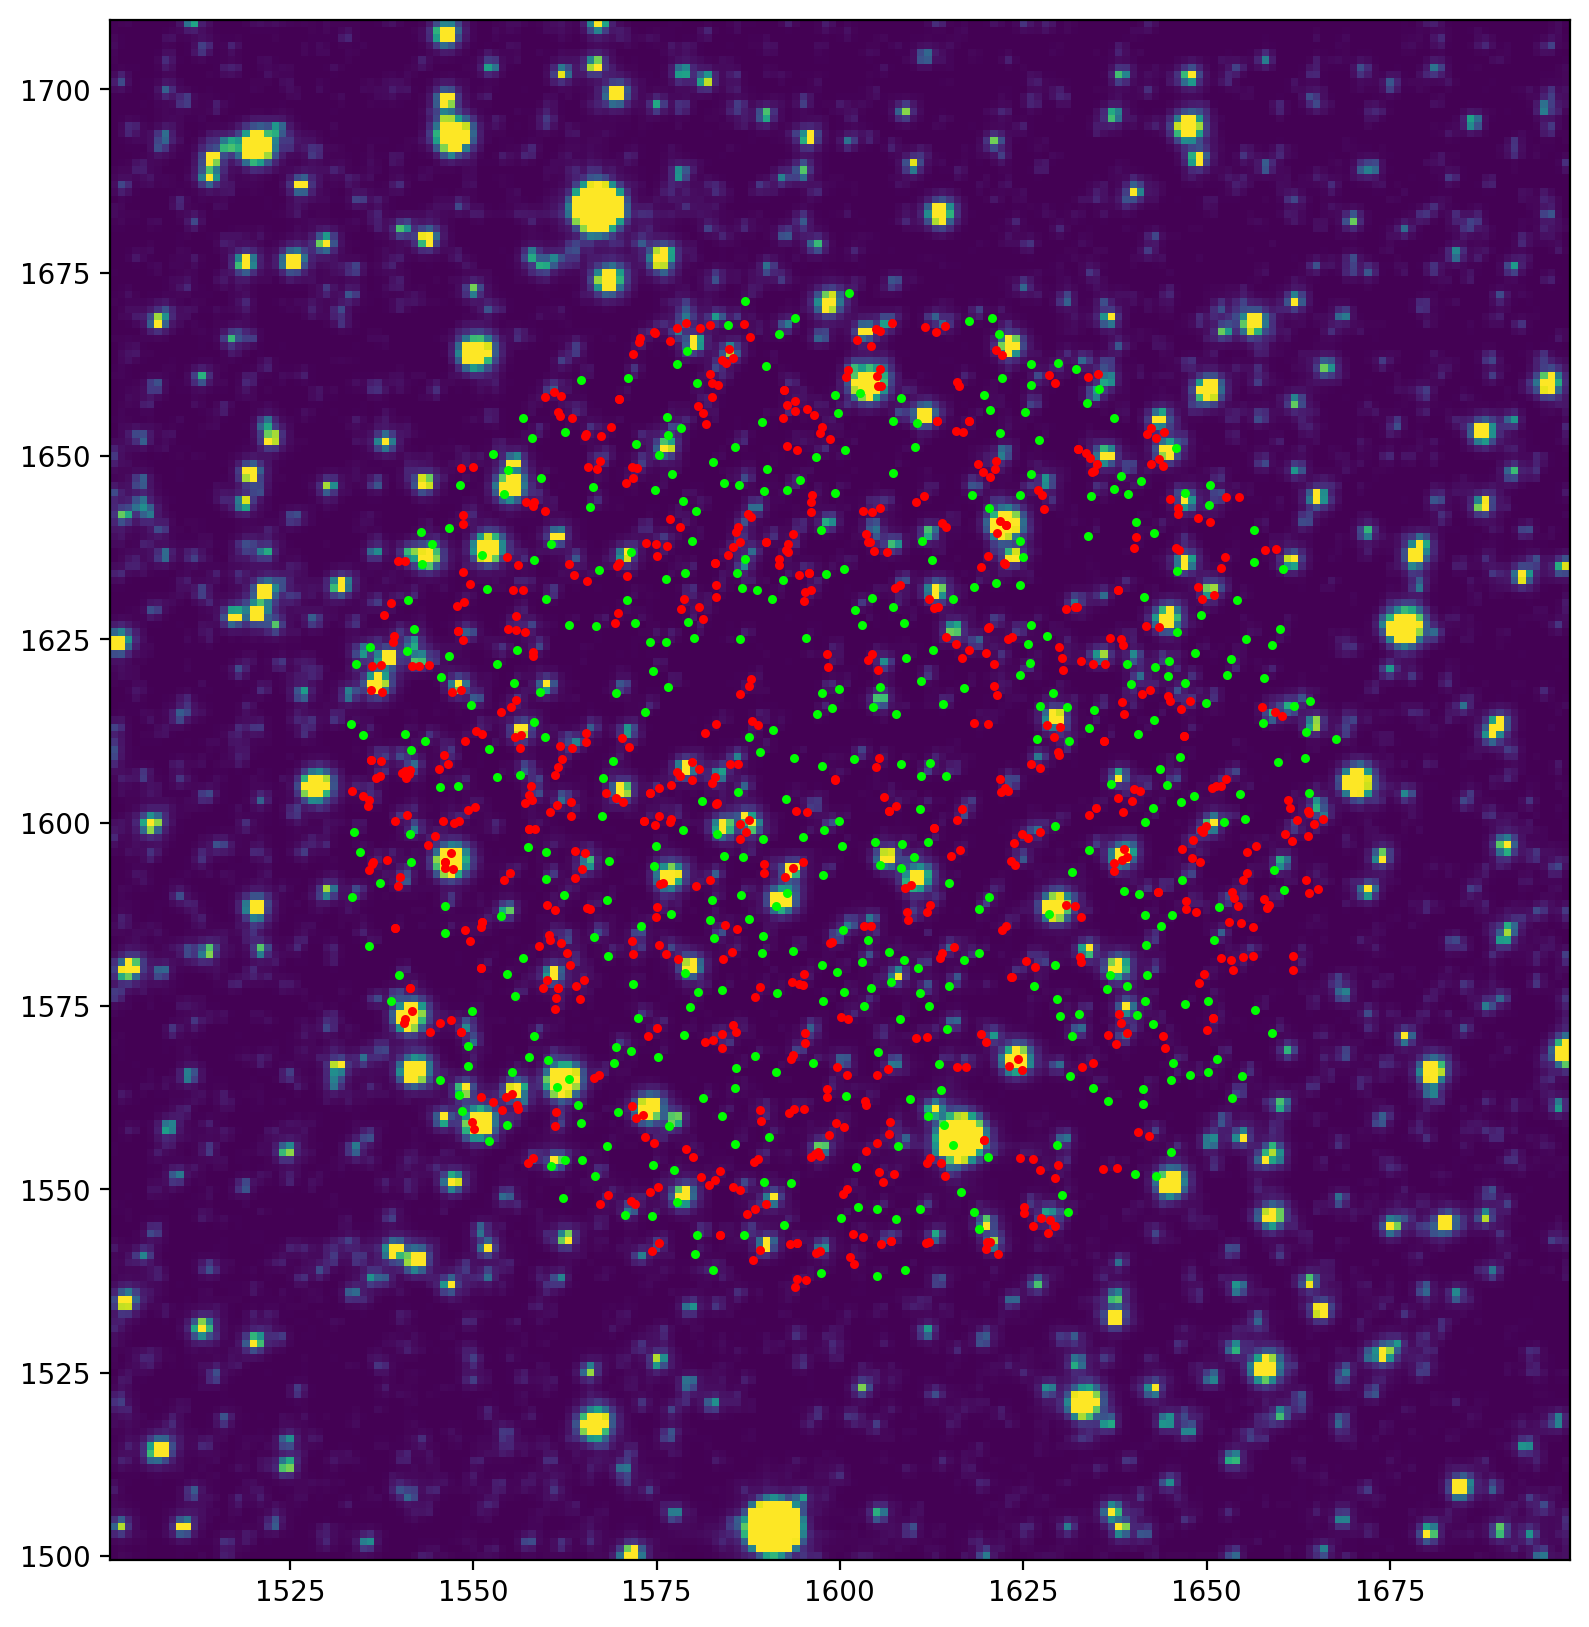

In [244]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, data, vmin=0, vmax=1000)
k = df.phot_rp_mean_flux > 1e3 
#plt.scatter(df["X0"][k], df["Y0"][k], s=5, c="r")
plt.scatter(df["X0"][isolated & k], df["Y0"][isolated & k], s=5, c="lime")
plt.scatter(df["X0"][~isolated & k], df["Y0"][~isolated & k], s=5, c="r")
plt.gca().set_aspect("equal")

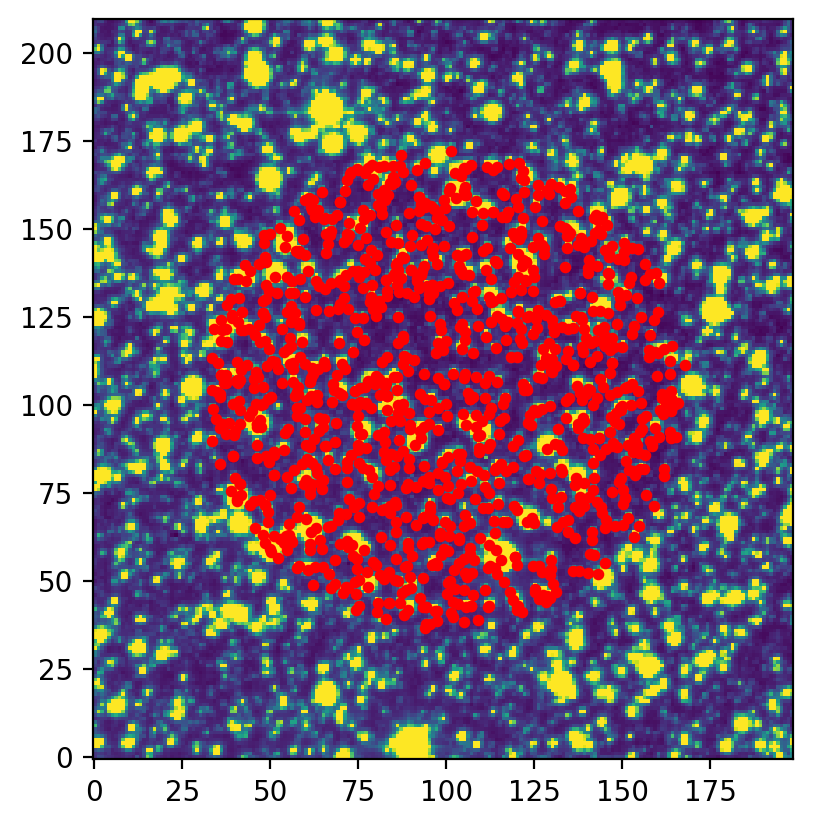

In [245]:
plt.imshow(data, origin='lower', vmax=100)
plt.scatter(df.X0[k] - 1500, df.Y0[k] - 1500, s=10, c='r')

In [253]:
x1 = np.asarray(df.X0[k & isolated]) - 1500
y1 = np.asarray(df.Y0[k & isolated]) - 1500
l = np.round(np.vstack([np.hstack([y1, y1, y1, y1-1, y1 + 1]), np.hstack([x1, x1-1, x1+1, x1, x1])]).T).astype(int)
dx, dy = np.hstack([x1] * 5) - l[:, 1], np.hstack([y1] * 5) - l[:, 0]
gf = np.hstack([np.asarray(df.phot_rp_mean_flux[k & isolated])] * 5) 

In [255]:
sigma = 1

In [288]:
X1 = np.vstack([dx**0, dx**2/(2*sigma**2), dy**2/(2*sigma**2)]).T

In [260]:
[-dx/sigma**2, -dy/sigma**2, 1/(np.ones_like(dx) * sigma**2)]

[array([ 0.39,  0.12,  0.05, ..., -0.41, -0.02, -0.16]),
 array([ 0.32, -0.23,  0.39, ...,  0.56,  1.34,  1.17]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [300]:
ye =2.5 * err[l[:, 0], l[:, 1]]/data[l[:, 0], l[:, 1]] * np.log(10)
y = np.log10(data[l[:, 0], l[:, 1]]/gf)
k = np.isfinite(y)
w = np.linalg.solve(X1[k].T.dot(X1[k]/ye[k, None]**2), X1[k].T.dot(y[k]/ye[k]**2))

/var/folders/bv/0t7fjlgx0mx3_3bdhxqzd7bmh_67k0/T/ipykernel_31559/1623728622.py:2: RuntimeWarning: invalid value encountered in log10
  y = np.log10(data[l[:, 0], l[:, 1]]/gf)


(-6.0, 3.0)

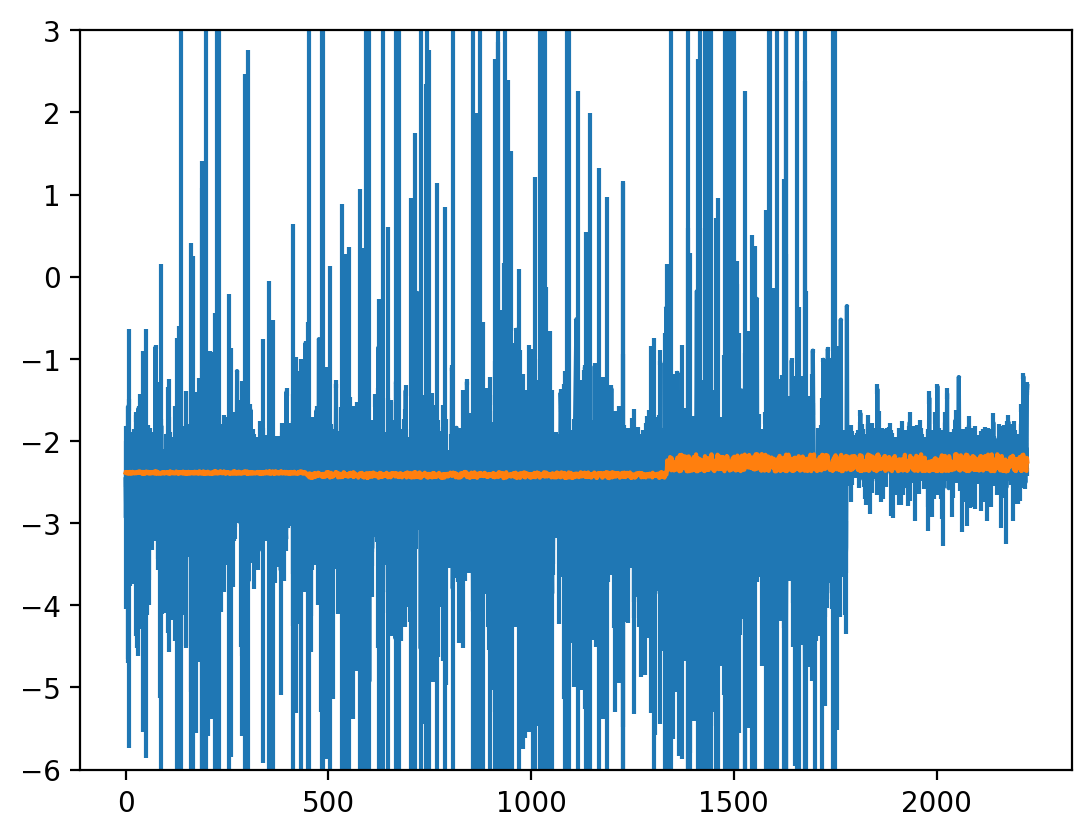

In [311]:
plt.errorbar(np.arange(len(y))[k], y[k], ye[k])
plt.plot(X1.dot(w), zorder=10)
plt.ylim(-6, 3)

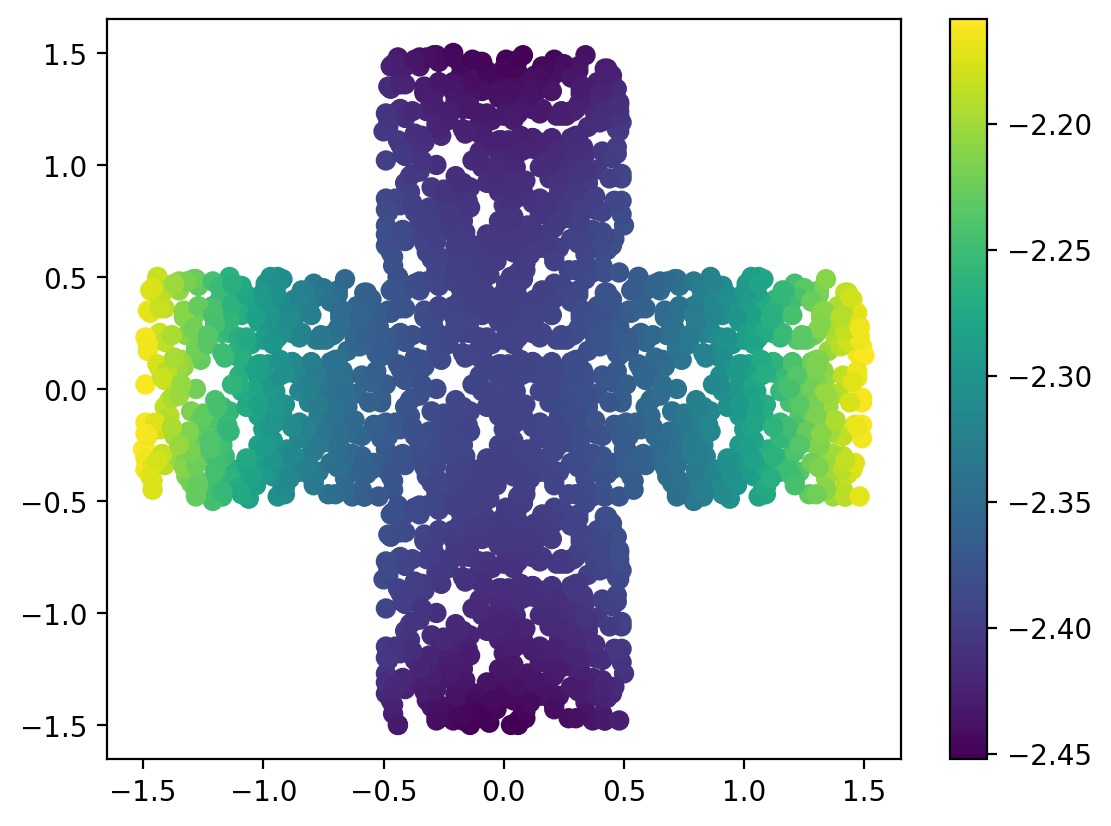

In [312]:
#plt.scatter(dy, dx, c=np.log10(data[l[:, 0], l[:, 1]]/gf), s=40)
plt.scatter(dy, dx, c=X1.dot(w), s=40)
plt.colorbar()

In [249]:
import astropy.units as u

In [252]:
print((0.003956838955*u.deg/u.day).to(u.arcsecond/u.day))

14.244620238 arcsec / d


In [67]:
wcs.wcs.crpix

array([1045., 1001.])

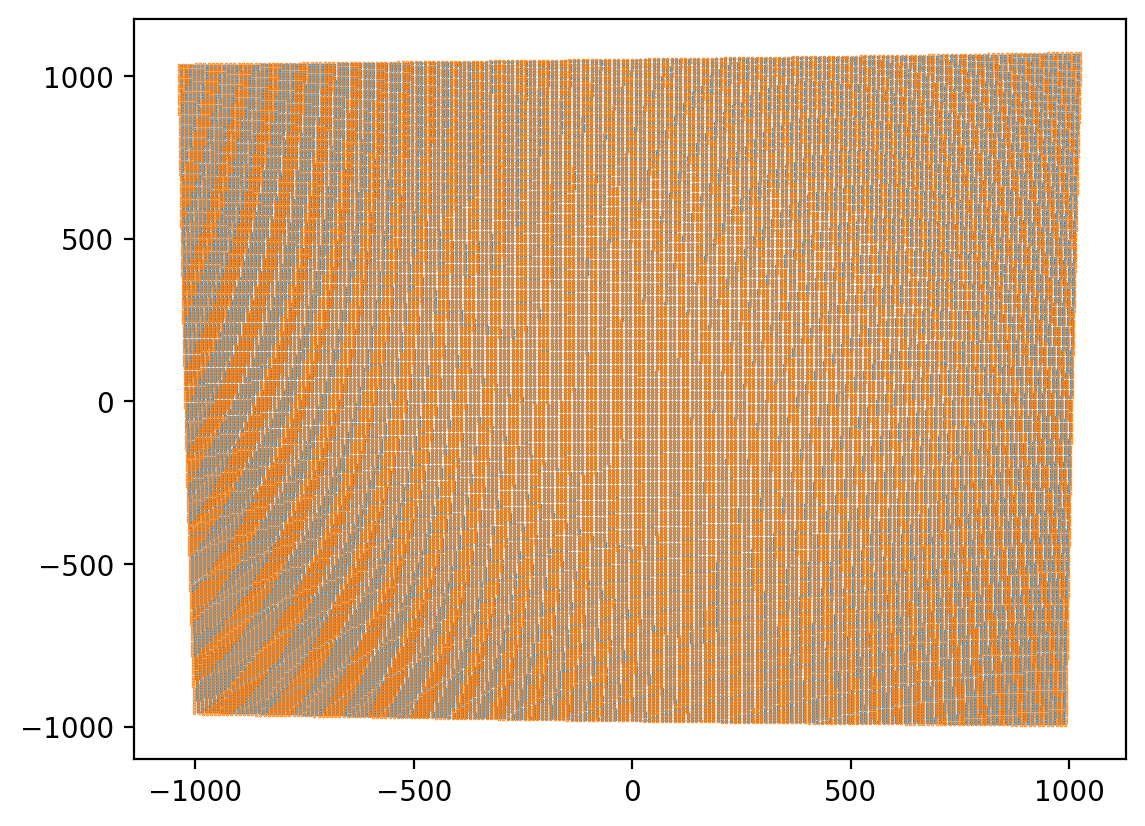

In [72]:
R, C = np.mgrid[0:204, 0:204] * 10
plt.scatter(*tess_wcs.sip.pix2foc(np.asarray([C.ravel(), R.ravel()]).T, 0).T, s=0.1)
plt.scatter(*wcs.sip.pix2foc(np.asarray([C.ravel(), R.ravel()]).T, 0).T, s=0.1)

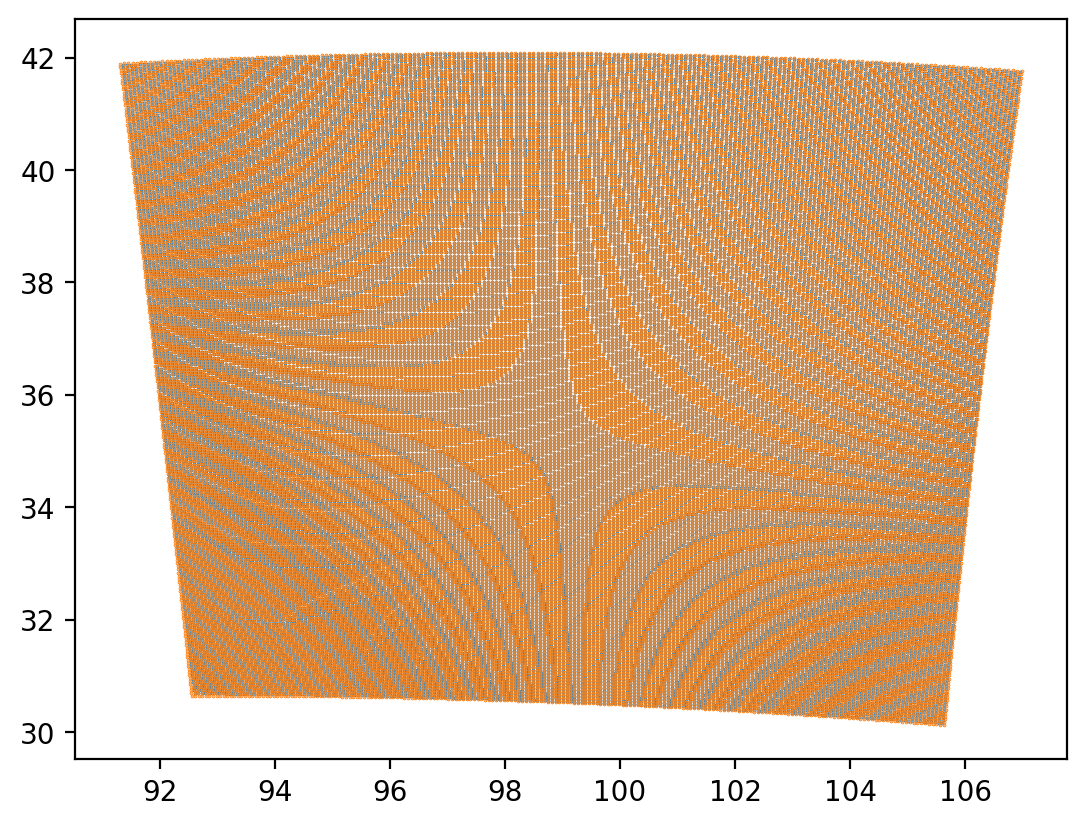

In [45]:
R, C = np.mgrid[0:204, 0:204] * 10
plt.scatter(*wcs.all_pix2world(np.asarray([C.ravel(), R.ravel()]).T, 0).T, s=0.1)
plt.scatter(*c_wcs.all_pix2world(np.asarray([C.ravel(), R.ravel()]).T, 0).T, s=0.1)

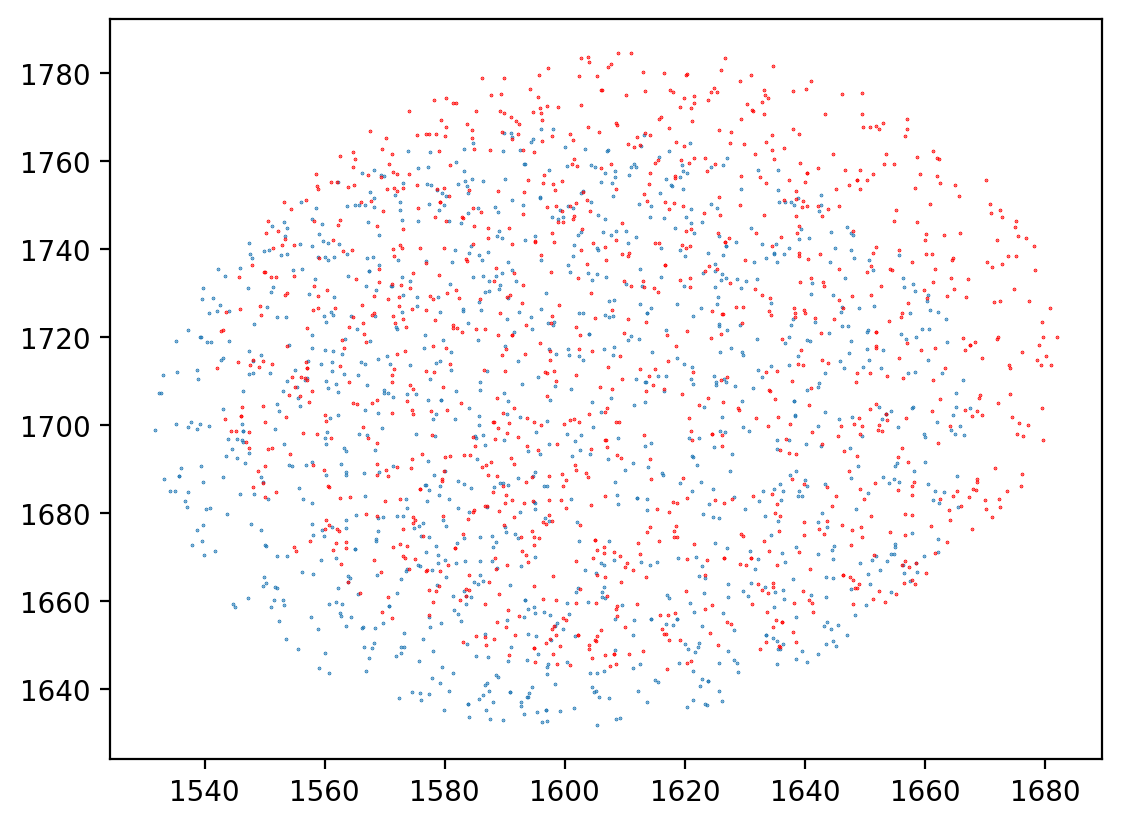

In [184]:
#plt.scatter(*wcs.wcs_world2pix(np.asarray([cs.ra.deg, cs.dec.deg]).T, 0).T, s=0.1)
plt.scatter(*wcs.all_world2pix(np.asarray([cs.ra.deg, cs.dec.deg]).T, 0).T, s=0.1)
plt.scatter(*c_wcs.wcs_world2pix(np.asarray([cs.ra.deg, cs.dec.deg]).T, 0).T, s=0.1, c='r')

In [137]:
c_wcs.wcs.pc = wcs.wcs.pc

AttributeError: No pc is present.

In [131]:
wcs.all_pix2world([wcs.wcs.crpix], 0)[0]

array([99.17402437, 36.10841495])

In [120]:
wcs.wcs.crval

array([99.16693895, 36.10287227])

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 99.16693894853834 36.10287227402947 
CRPIX : 1045.0 1001.0 
CD1_1 CD1_2  : 0.005703780024744337 2.032501456439169e-05 
CD2_1 CD2_2  : -0.000165307076556 0.005707963569991766 
NAXIS : 2136  2078